__Restricted Boltzmann Machine features for digit classification__

For greyscale image data where pixel values can be interpreted as degrees of
blackness on a white background, like handwritten digit recognition, the
Bernoulli Restricted Boltzmann machine model (:class:`BernoulliRBM
<sklearn.neural_network.BernoulliRBM>`) can perform effective non-linear
feature extraction.

Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve    
License: BSD


https://scikit-learn.org/dev/auto_examples/neural_networks/plot_rbm_logistic_classification.html

In [1]:
%matplotlib inline

## Generate data

In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data with
linear shifts of 1 pixel in each direction.



In [3]:
import numpy as np
from numpy import random as rng

---

In [4]:
# https://habr.com/ru/company/plarium/blog/512332/

# from sklearn.datasets import fetch_lfw_people 
# from sklearn.datasets import fetch_olivetti_faces
# from sklearn.datasets import fetch_lfw_pairs
# from sklearn.datasets import load_digits

# from sklearn.datasets import fetch_openml  # https://www.openml.org
# data = fetch_openml(name='Kuzushiji-MNIST')
# data = fetch_openml(name='Fashion-MNIST')
# print( data.keys() )
# X = data['data'].values.reshape(70000,28,28)
# target = data['target'].astype(np.uint8).values

# X,target = fetch_openml( name='Fashion-MNIST', as_frame=False, return_X_y=True)


---

In [5]:
from sklearn.datasets import load_digits
data = load_digits()
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [6]:
from matplotlib import pyplot as plt

images = data['images']
n_show = 50

plt.figure(figsize=(16,2))
for n,i in enumerate(rng.permutation(len(images))[:n_show], start=1):
    plt.subplot(1,n_show,n)
    plt.axis(False)
    plt.imshow(images[i],cmap='gray_r')

In [7]:
X, y = data['data'].astype(np.float32), data['target'].astype(np.uint8)
X.shape, y.shape

((1797, 64), (1797,))

---

In [8]:
from scipy.ndimage import convolve
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

X, Y = nudge_dataset(X, y)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Models definition

We build a classification pipeline with a BernoulliRBM feature extractor and
a :class:`LogisticRegression <sklearn.linear_model.LogisticRegression>`
classifier.



In [9]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)

rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

## Training

The hyperparameters of the entire model (learning rate, hidden layer size,
regularization) were optimized by grid search, but the search is not
reproduced here because of runtime constraints.



In [10]:
# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.57, time = 0.12s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.68, time = 0.13s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.88, time = 0.13s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.13s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.79, time = 0.13s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -20.96, time = 0.13s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.80, time = 0.13s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.63, time = 0.13s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.38, time = 0.13s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.19, time = 0.12s


Pipeline(steps=[('rbm',
                 BernoulliRBM(learning_rate=0.06, n_components=100,
                              random_state=0, verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, solver='newton-cg', tol=1))])

In [11]:
from sklearn.base import clone

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

LogisticRegression(C=100.0, solver='newton-cg', tol=1)

## Evaluation



In [12]:
from sklearn import metrics

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.90      0.93      0.91       184
           2       0.93      0.95      0.94       166
           3       0.94      0.88      0.91       194
           4       0.95      0.94      0.95       186
           5       0.93      0.92      0.93       181
           6       0.98      0.97      0.97       207
           7       0.94      0.99      0.97       154
           8       0.89      0.88      0.88       182
           9       0.88      0.90      0.89       169

    accuracy                           0.93      1797
   macro avg       0.93      0.94      0.93      1797
weighted avg       0.93      0.93      0.93      1797




In [13]:
Y_pred = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       174
           1       0.60      0.58      0.59       184
           2       0.75      0.85      0.80       166
           3       0.78      0.78      0.78       194
           4       0.81      0.83      0.82       186
           5       0.76      0.76      0.76       181
           6       0.90      0.87      0.89       207
           7       0.86      0.88      0.87       154
           8       0.67      0.59      0.63       182
           9       0.76      0.76      0.76       169

    accuracy                           0.78      1797
   macro avg       0.78      0.78      0.78      1797
weighted avg       0.78      0.78      0.78      1797




The features extracted by the BernoulliRBM help improve the classification
accuracy with respect to the logistic regression on raw pixels.



## Plotting



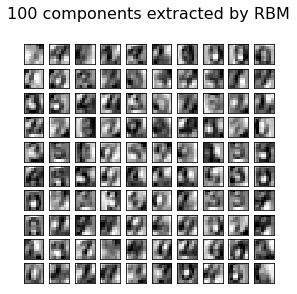

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()